In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import multivariate_normal
from scipy.stats import norm

import pandas as pd
import statsmodels.formula.api as smf
from sklearn.linear_model import Ridge

In [7]:
# data generating process
def f(X):
    '''True regression function.'''
    return .01*((X[:, 0]-2)**3 + X[:, 1]**3 + -3*X[:, 1]*X[:, 0] + -2*X[:, 2]**3)

# generate artificial training data
mu = np.array([1, 3, 5])         # mean
sigma = np.array([[ 9, -5, -4],
                  [-5, 11,  9],
                  [-4,  9, 13]]) # covariance matrix
n = 100                          # sample size

# joint normal rv for X
mvnorm = multivariate_normal(mu, sigma)

# noise
noise = norm(0, 3)

X = mvnorm.rvs(n)
eps = noise.rvs(n)
y = (f(X) + eps).reshape(n,1)

# put data in dataframe
df = pd.DataFrame(data=np.hstack((y, X)), columns=['y', 'x1', 'x2', 'x3'])

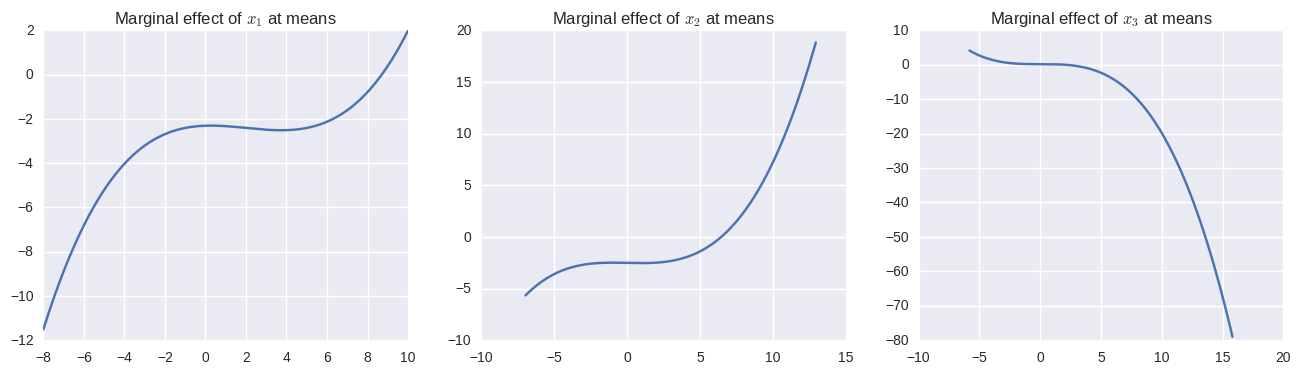

In [8]:
# Plot partial effects on regression function

n_linsp = 500

# constant for means
O = np.ones((n_linsp, 1))

# standard deviation for relevant range
sd1 = np.sqrt(sigma[0, 0])
sd2 = np.sqrt(sigma[1, 1])
sd3 = np.sqrt(sigma[2, 2])

# range where data fall with 99% chance
R1 = np.linspace(mu[0]-3*sd1, mu[0]+3*sd1, n_linsp).reshape((n_linsp,1))
R2 = np.linspace(mu[1]-3*sd2, mu[1]+3*sd2, n_linsp).reshape((n_linsp,1))
R3 = np.linspace(mu[2]-3*sd3, mu[2]+3*sd3, n_linsp).reshape((n_linsp,1))

fig, ax = plt.subplots(1, 3, figsize=(16, 4))

ax[0].plot(R1, f(np.hstack((R1, O*mu[1], O*mu[2]))), label='x1')
ax[0].set_title('Marginal effect of $x_1$ at means')
ax[1].plot(R2, f(np.hstack((O*mu[0], R2, O*mu[2]))), label='x2')
ax[1].set_title('Marginal effect of $x_2$ at means')
ax[2].plot(R3, f(np.hstack((O*mu[0], O*mu[1], R3))), label='x3')
ax[2].set_title('Marginal effect of $x_3$ at means')
plt.show()

In [9]:
# test sample

n_out = 10000
X_out = mvnorm.rvs(n_out)
eps_out = noise.rvs(n_out)
y_out = (f(X_out) + eps_out)#.reshape(n_out,1)

X_out = pd.DataFrame(data=X_out, columns=['x1', 'x2', 'x3'])

In [10]:
# fit model with interactions and second order terms

# define regression formula 
form = 'y ~ x1 + x2 + x3 + I(x1**2) + I(x2**2) + I(x3**2) + x1:x2 + x1:x3 + x2:x3'

# estimate and get risk for OLS
# =============================

mod = smf.ols(formula=form, data=df)
res = mod.fit()
y_OLS_hat = res.predict(X_out)
R_OLS = ((y_out - y_OLS_hat)**2).mean() - noise.var()

# estimate an get risk for Ridge
# (for multiple penalty parameters)
# =================================

# range of penalty parameter
n_penalty = 40
penalty_end = 7
penalty = np.linspace(0, penalty_end, n_penalty)

R_Ridge = []
for a in penalty:
    res_reg = mod.fit_regularized(alpha=a, L1_wt=0)
    y_Ridge_hat = res_reg.predict(X_out)
    R_Ridge.append(((y_out - y_Ridge_hat)**2).mean() - noise.var())

R_Ridge = np.array(R_Ridge)

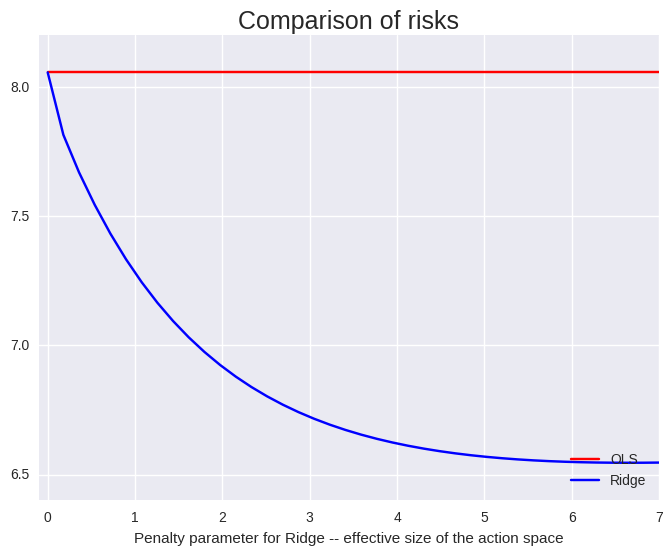

In [11]:
# plot risk for OLS and Ridge

R_OLS_vect = np.ones(n_penalty)*R_OLS

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(penalty, R_OLS_vect, color='r', label='OLS')
ax.plot(penalty, R_Ridge, color='b', label='Ridge')
ax.set_title('Comparison of risks', fontsize=18)
ax.set_xlabel('Penalty parameter for Ridge -- effective size of the action space')
ax.set_xlim([-.1, penalty_end])
#ax.set_ylim([6, 9])
plt.legend(loc=4)
plt.show()

In [8]:
print('OLS Regression')
print('==========================')
print(res.params)
print('==========================')
print('Ridge Regression')
print(res_reg.params)
print('==========================')

OLS Regression
Intercept     1.550222
x1           -0.343776
x2           -0.490669
x3            0.813521
I(x1 ** 2)   -0.047913
I(x2 ** 2)    0.048497
I(x3 ** 2)   -0.330037
x1:x2        -0.011382
x1:x3         0.092873
x2:x3         0.140582
dtype: float64
Ridge Regression
Intercept     0.195523
x1           -0.024900
x2            0.024312
x3            0.428689
I(x1 ** 2)   -0.037676
I(x2 ** 2)    0.086387
I(x3 ** 2)   -0.254636
x1:x2        -0.049150
x1:x3         0.092124
x2:x3         0.028911
dtype: float64


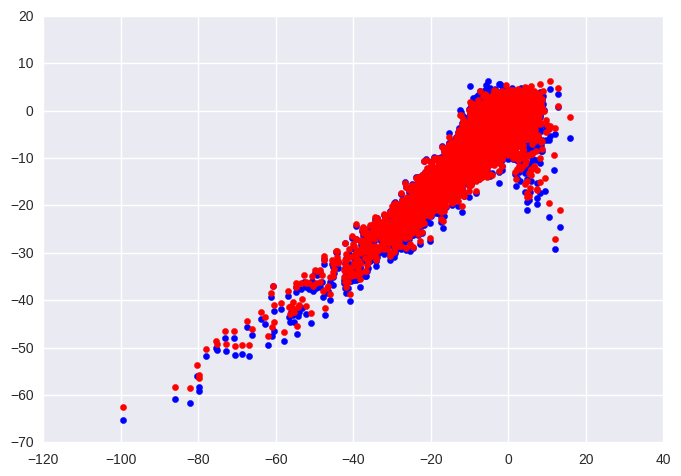

In [9]:
res_reg = mod.fit_regularized(alpha=penalty[np.argmin(R_Ridge)], L1_wt=0)
y_Ridge_hat = res_reg.predict(X_out)

plt.scatter(y_out, y_OLS_hat, color='b')
plt.scatter(y_out, y_Ridge_hat, color='r')
plt.show()